#  Drawing flight routes on the US with NetworkX

In [15]:
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [16]:
# https://openflights.org/data.html#route

names = ('airline,airline_id,'
         'source,source_id,'
         'dest,dest_id,'
         'codeshare,stops,equipment').split(',')

df_routes = pd.read_csv("data/routes.dat", 
    names=names,
    header=None)

print(len(df_routes))
df_routes.head()

67663


,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


## We load the second dataset with details about the airports, and we only keep the airports from the United States:

In [17]:
# https://openflights.org/data.html#airport
names = ('id,name,city,country,iata,icao,lat,long,'
         'alt,timezone,dst,tz,type,source').split(',')

df_airports = pd.read_csv("data/airports.dat", header= None, names=names,  index_col=4, na_values='\\N')
airports_us = df_airports[df_airports['country'] == 'United States']
airports_us.head()

,id,name,city,country,icao,lat,long,alt,timezone,dst,tz,type,source
iata,,,,,,,,,,,,,
BTI,3411,Barter Island LRRS Airport,Barter Island,United States,PABA,70.134003,-143.582001,2,-9.0,A,America/Anchorage,airport,OurAirports
NaN,3412,Wainwright Air Station,Fort Wainwright,United States,PAWT,70.613403,-159.860001,35,-9.0,A,America/Anchorage,airport,OurAirports
LUR,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,PALU,68.875099,-166.110001,16,-9.0,A,America/Anchorage,airport,OurAirports
PIZ,3414,Point Lay LRRS Airport,Point Lay,United States,PPIZ,69.732903,-163.005005,22,-9.0,A,America/Anchorage,airport,OurAirports
ITO,3415,Hilo International Airport,Hilo,United States,PHTO,19.721399,-155.048004,38,-10.0,N,Pacific/Honolulu,airport,OurAirports


Let's keep all national US flight routes, that is, those for which the source and the destination airports belong to the list of US airports:

In [18]:
routes_us = df_routes[ df_routes['source'].isin(airports_us.index) & df_routes['dest'].isin(airports_us.index)]
routes_us.head()

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
172,2O,146,ADQ,3531,KLN,7162,NaN,0,BNI
177,2O,146,KLN,7162,KYK,7161,NaN,0,BNI
260,3E,10739,BRL,5726,ORD,3830,NaN,0,CNC
261,3E,10739,BRL,5726,STL,3678,NaN,0,CNC
262,3E,10739,DEC,4042,ORD,3830,NaN,0,CNC


## We construct the list of edges representing our graph, where nodes are airports, and two airports are connected if there exists a route between them (flight network):

In [19]:
edges = routes_us[['source', 'dest']].values
edges

array([['ADQ', 'KLN'],
       ['KLN', 'KYK'],
       ['BRL', 'ORD'],
       ...,
       ['SOW', 'PHX'],
       ['VIS', 'LAX'],
       ['WRL', 'CYS']], dtype=object)

In [20]:
g = nx.from_edgelist(edges)

In [21]:
len(g.nodes()), len(g.edges())

(546, 2781)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


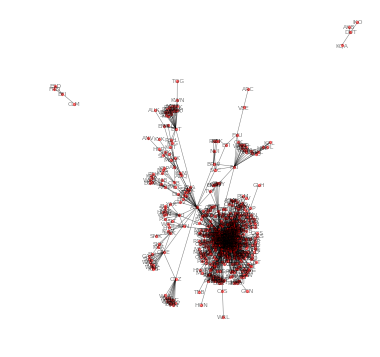

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [23]:
sg = next(nx.connected_component_subgraphs(g))

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


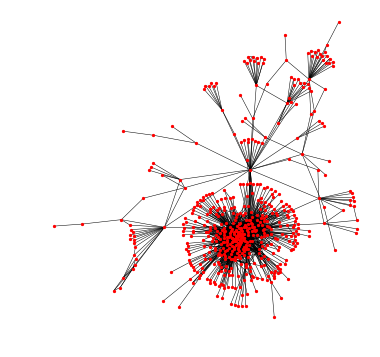

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(sg, ax=ax, with_labels=False,
                 node_size=5, width=.5)
ax.set_axis_off()

In [25]:
airports_us =airports_us[~airports_us.index.duplicated(keep='first')]

pos = {airport: (v['long'], v['lat'])
      for airport, v in  airports_us.to_dict('index').items()}

In [26]:
deg = nx.degree(sg)
sizes = [5 * deg[iata] for iata in sg.nodes]

In [27]:
labels = {iata: iata if deg[iata] >= 20 else ''
          for iata in sg.nodes}

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


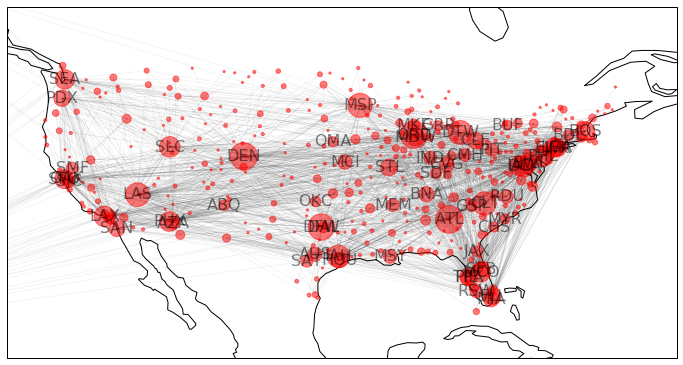

In [28]:
# Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()
# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                 node_color='red',
                 cmap=plt.cm.autumn
                )